In [1]:
from bunyip import Bunyip
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import pandas as pd
import phoebe

In [2]:
# time, flux = np.loadtxt('phoetting/data/lc.kepler.data.txt', usecols=(0,1)).T
# time, flux = np.loadtxt('lcs/lc002.data', usecols=(0,1)).T
time, flux = np.loadtxt('../../../Dropbox (Sydney Uni)/Projects/A draconis/thuban/data/photometry/adra_sap_spline_corrected.txt', usecols=(0,1)).T
flux /= np.median(flux)
# Load it up into bunyip. Bunyip takes phas and flux but I wrote a convenience function for time and flux:
bn = Bunyip.from_lightcurve(time, flux, period=51.4213, #t0=0.#0.5
                           )

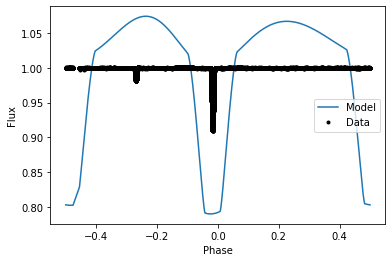

In [5]:
# Update parameters from KNN
# bn.update_from_knn()
# bn.update_from_geometry(diagnose=True)
# bn.parameters['t0'] = -0.5
bn.plot_model()

In [6]:
_ = bn.optimize_best(options={
    'adaptive': True
})

 20%|██        | 1/5 [01:06<04:27, 66.94s/it]

KeyboardInterrupt: 

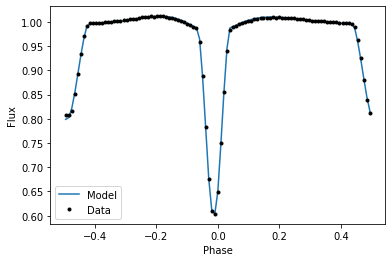

In [7]:
bn.plot_model()

In [8]:
bn.parameters

{'q': 1.3519833553586798,
 'rsum': 0.38064295652929925,
 'rratio': 0.5914345649406442,
 'fc': -0.07942475420134595,
 'fs': -0.41309926306642114,
 'sbratio': 1.7079104920471941,
 'incl': 83.52642569553315,
 't0': -0.4915739787896902,
 'mean': -0.005193430004643232,
 'log_f': -5.971386540334555,
 'gdc_1': -0.003584317995959735,
 'gdc_2': -0.00036130674629926125}

Run Checks Report: WARNING


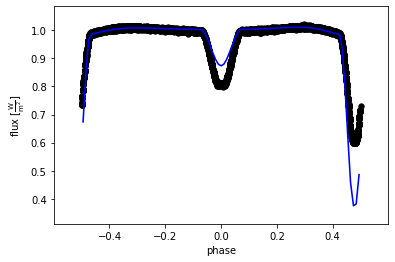

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 432x288 with 1 Axes>)

In [10]:
p = bn.to_phoebe(time, flux)
# p['teffratio'] = (bn.parameters['sbratio'] / (bn.parameters['rratio'] **2)) **(1/4)
p.run_compute()
p.plot(show=True, x='phase')

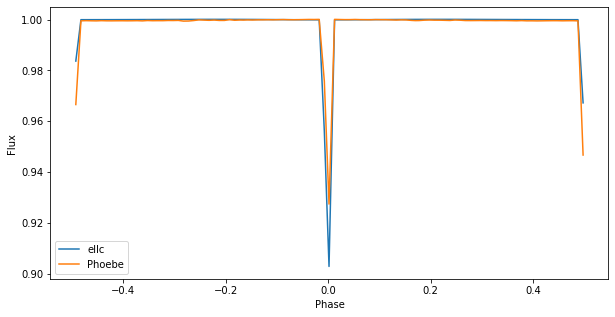

In [56]:
phoebe_flux = p['value@fluxes@latest']
plt.figure(figsize=[10,5])
plt.plot(bn.phase, bn.lc_model(), label='ellc')
plt.plot(bn.phase, phoebe_flux, label='Phoebe')
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.legend()

# plt.savefig('test.png', dpi=300, bbox_inches='tight')

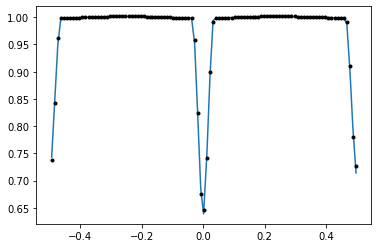

In [45]:
import astropy.units as u

b = p
hier = p.get_hierarchy()
starrefs  = hier.get_stars()
orbitrefs = hier.get_orbits()

orbitref = orbitrefs[0]

shape_1 = p.get_value(qualifier='distortion_method', component=starrefs[0])
shape_2 = p.get_value(qualifier='distortion_method', component=starrefs[1])

a = b.get_value(qualifier='sma', component=orbitref, context='component', unit=u.solRad)
radius_1 = b.get_value(qualifier='requiv', component=starrefs[0], context='component', unit=u.solRad) / a
radius_2 = b.get_value(qualifier='requiv', component=starrefs[1], context='component', unit=u.solRad) / a

# period = b.get_value(qualifier='period', component=orbitref, context='component', unit=u.d)
q = b.get_value(qualifier='q', component=orbitref, context='component')

# TODO: there seems to be a convention flip between primary and secondary star in ellc... maybe we can just address via t_zero?
t_zero = b.get_value(qualifier='t0_supconj', component=orbitref, context='component', unit=u.d)

incl = b.get_value(qualifier='incl', component=orbitref, context='component', unit=u.deg)
didt = 0.0

ecc = b.get_value(qualifier='ecc', component=orbitref, context='component')
w = b.get_value(qualifier='per0', component=orbitref, context='component', unit=u.rad)

# domdt = b.get_value(qualifier='dperdt', component=orbitref, context='component', unit=u.deg/u.d) * period

gdc_1 = b.get_value(qualifier='gravb_bol', component=starrefs[0], context='component')
gdc_2 = b.get_value(qualifier='gravb_bol', component=starrefs[1], context='component')

rotfac_1 = b.get_value(qualifier='syncpar', component=starrefs[0], context='component')
rotfac_2 = b.get_value(qualifier='syncpar', component=starrefs[1], context='component')

f_c = np.sqrt(ecc) * np.cos(w)
f_s = np.sqrt(ecc) * np.sin(w)

# note: these aren't true surface brightnesses, but the ratio should be fine
# sb_primary = b.get_value(qualifier='pblum', component=starrefs[0], context='dataset', unit=u.W, check_visible=False) / b.get_value(qualifier='requiv', component=starrefs[0], context='component', unit=u.solRad)**2
# sb_secondary = b.get_value(qualifier='pblum', component=starrefs[1], context='dataset', unit=u.W, check_visible=False) / b.get_value(qualifier='requiv', component=starrefs[1], context='component', unit=u.solRad)**2
# sb_ratio =  sb_secondary / sb_primary

sb_primary = 4 * np.pi**2 * b.get_value(qualifier='requiv', component=starrefs[0], context='component', unit=u.solRad)**2 * (b['value@teff@primary']**4)
sb_secondary = 4 * np.pi**2 * b['value@requiv@secondary']**2 * (b['value@teff@secondary@component']**4)
sb_ratio = sb_secondary / sb_primary
t_exp = b.get_value(qualifier='exptime', context='dataset')

n_int = 1
import ellc
fluxes = ellc.lc(bn.phase,
                 radius_1, radius_2,
                 sb_ratio,
                 incl,
                 t_zero=t_zero, period=1, a=a, q=q,
                 f_c=f_c, f_s=f_s,
                 ldc_1=None, ldc_2=None,
                 gdc_1=gdc_1, gdc_2=gdc_2,
                 didt=didt, 
                 rotfac_1=rotfac_1, rotfac_2=rotfac_2,
                 bfac_1=None, bfac_2=None,
                 heat_1=None, heat_2=None,
                 lambda_1=None, lambda_2=None,
                 vsini_1=None, vsini_2=None,
                 t_exp=t_exp, n_int=n_int,
                 ld_1=None, ld_2=None,
                 shape_1=shape_1, shape_2=shape_2,
                 spots_1=None, spots_2=None,
                 verbose=1)
# fluxes *= b.get_value(qualifier='pbflux', context='dataset', unit=u.W/u.m**2, check_visible=False)
fluxes /= np.median(fluxes)
plt.plot(bn.phase, fluxes)# + bn.parameters['mean'])
plt.plot(bn.phase, bn.flux,'.k')

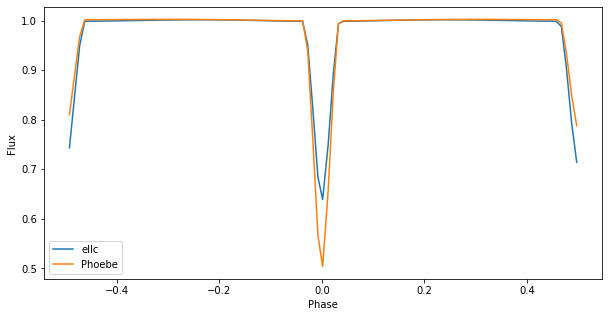

In [46]:
phoebe_flux = p['value@fluxes@latest']
plt.figure(figsize=[10,5])
plt.plot(bn.phase, fluxes, label='ellc')
plt.plot(bn.phase, phoebe_flux, label='Phoebe')
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.legend()

# plt.savefig('test.png', dpi=300, bbox_inches='tight')

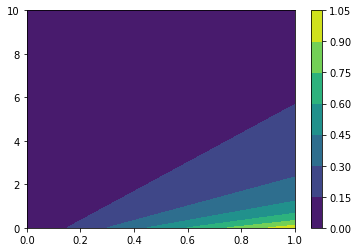

In [64]:
a = np.linspace(0, 1, 100)
b = np.linspace(0, 10, 100)
A, B = np.meshgrid(a, b)
r1, r2 = A/(1.+B), A*B/(1.+B)

plt.contourf(A, B, r1)
plt.colorbar()

In [ ]:
bounds = [
    (0., 2),
    ()
]

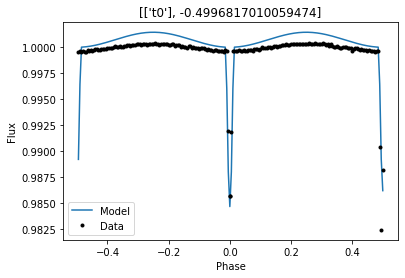

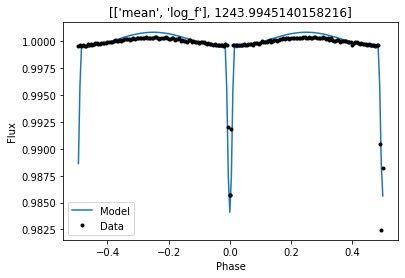

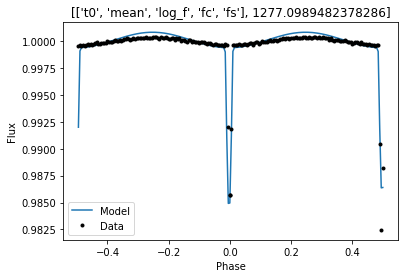

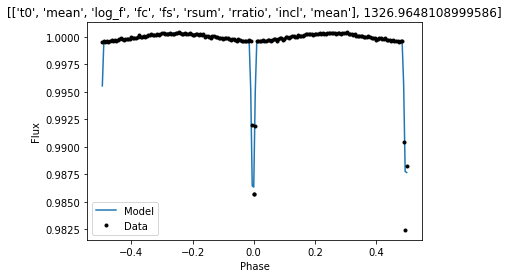

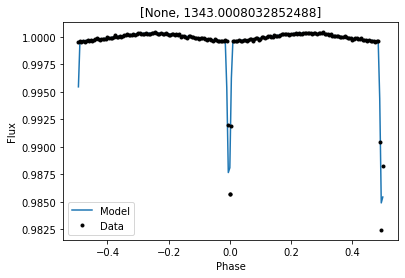

In [6]:
optimization_path = [
    ['t0'],
    ['mean', 'log_f'],
    ['t0', 'mean', 'log_f', 'fc', 'fs'],
    ['t0', 'mean', 'log_f', 'fc', 'fs', 'rsum', 'rratio', 'incl', 'mean'],
    None # All parameters
]

for path in optimization_path:
    soln = bn.optimize(vars=path, method='Nelder-Mead')
    ax = bn.plot_model()
    ax.set_title([path, bn.lnlike([],[])])
    plt.show()

In [9]:
# And run some emcee
trace = bn.run_emcee()

 89%|████████▉ | 2674/3000 [10:57<01:16,  4.25it/s]/Users/danielhey/Dropbox (Sydney Uni)/code/Bunyip/bunyip/bunyip.py:279: RuntimeWarning: overflow encountered in square
  """log prior of the ellc model
/Users/danielhey/Dropbox (Sydney Uni)/code/Bunyip/bunyip/bunyip.py:281: RuntimeWarning: overflow encountered in square
  Returns
/Users/danielhey/Dropbox (Sydney Uni)/code/Bunyip/bunyip/bunyip.py:281: RuntimeWarning: invalid value encountered in true_divide
  Returns
100%|██████████| 3000/3000 [12:04<00:00,  4.14it/s]


In [20]:
lcs = bn.get_model_from_trace(trace, n=500)

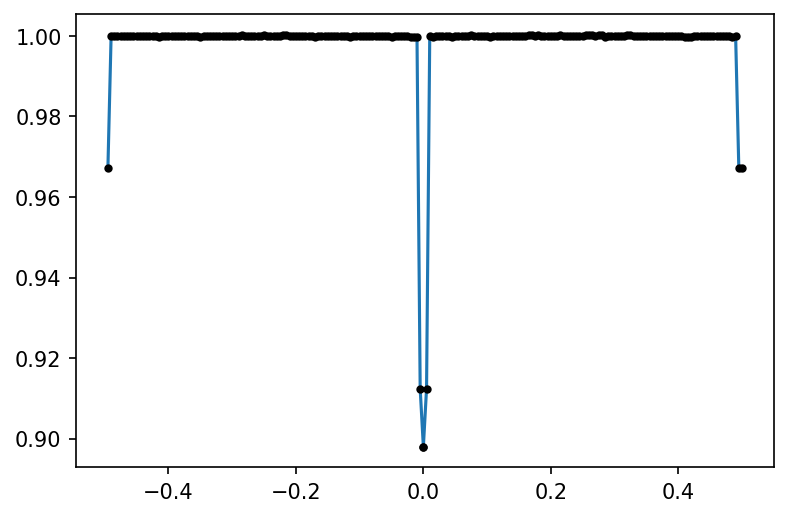

In [22]:
med = np.median(lcs, axis=0)
sd = np.std(lcs, axis=0)
plt.plot(bn.phase, med)
plt.fill_between(bn.phase, med-sd, med+sd, alpha=0.5)
plt.plot(bn.phase, bn.flux, '.k')

 44%|████▍     | 4/9 [02:14<02:38, 31.66s/it]/Users/danielhey/anaconda3/envs/phoebe/lib/python3.7/site-packages/scipy/optimize/optimize.py:597: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):
No handles with labels found to put in legend.
 67%|██████▋   | 6/9 [03:02<01:28, 29.64s/it]/Users/danielhey/anaconda3/envs/phoebe/lib/python3.7/site-packages/scipy/optimize/optimize.py:597: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):
No handles with labels found to put in legend.
100%|██████████| 9/9 [04:23<00:00, 29.24s/it]


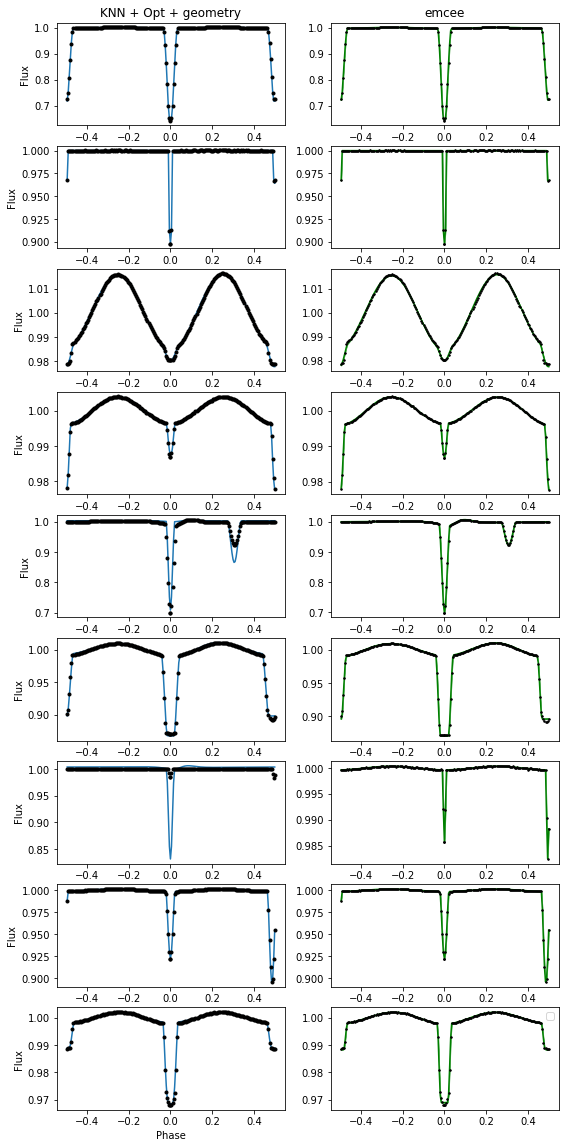

In [3]:
import glob
from tqdm import tqdm

files = sorted(glob.glob('lcs/*.data'))
traces = sorted(glob.glob('lcs/ellc_traces/*.data.txt'))

fig, axes = plt.subplots(9,2, figsize=[9,20])

for file, trace, ax in tqdm(zip(files, traces, axes), total=len(files)):
    time, flux = np.loadtxt(file, usecols=(0,1)).T
    # I also know the orbital period is the last data point
    period = time[-1]
    bn = Bunyip.from_lightcurve(time, flux, period=period)
    bn.update_from_knn()
    bn.update_from_geometry(diagnose=False)
    
    optimization_path = [
    ['t0'],
    ['mean', 'log_f'],
    ['t0', 'mean', 'log_f', 'fc', 'fs'],
    ['t0', 'mean', 'log_f', 'fc', 'fs', 'rsum', 'rratio', 'incl', 'mean'],
    None # All parameters
    ]

    for path in optimization_path:
        soln = bn.optimize(vars=path, method='Nelder-Mead')
    bn.plot_model(ax=ax[0])
    
    tr = np.loadtxt(trace)
    lcs = bn.get_model_from_trace(tr, n=5)
    med = np.median(lcs, axis=0)
    sd = np.std(lcs, axis=0)
    ax[1].plot(bn.phase, med, c='green')
    ax[1].fill_between(bn.phase, med-sd, med+sd, alpha=0.5, color='green')
    ax[1].plot(bn.phase, bn.flux, '.k', markersize=3)
    
axes[0][0].set_title('KNN + Opt + geometry')  
axes[0][1].set_title('emcee')

plt.savefig('results.png', dpi=300, bbox_inches='tight')

In [125]:
bn.parameters

{'q': 0.7707335867644016,
 'rsum': 0.2000935205097809,
 'rratio': 0.9154035767547292,
 'fc': 1.2530333031024253e-08,
 'fs': 1.2530333031024257e-08,
 'sbratio': 0.9000853788169647,
 'incl': 79.46026146951336,
 't0': 0.0,
 'mean': 0.0,
 'log_f': 0.002290688235883099,
 'gdc_1': 0,
 'gdc_2': 0}

In [65]:
from bunyip.phoetter import Phoetter

In [113]:
p = Phoetter()
p.add_dataset('lc', times=np.zeros_like(flux), fluxes=flux)
p.flip_constraint('compute_phases', 'compute_times')
p.set_value('compute_phases', np.linspace(-0.5,0.5,50))

In [119]:
p['period@orbit'] = 2.

In [123]:
p.set_value('period@orbit', 5)

In [120]:
p.run_compute()

<ParameterSet: 4 parameters | contexts: figure, model>

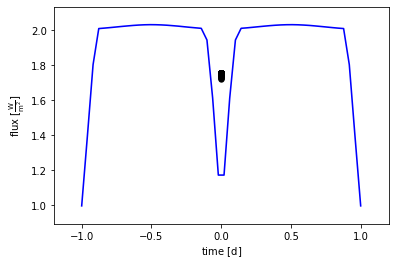

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 432x288 with 1 Axes>)

In [121]:
p.plot(show=True)

In [68]:
qs = []
qs_err = []
r1s, r2s, incls, ecosws, esinws, omegas, sbratios = [], [], [], [], [], [], []
r1s_err, r2s_err, incls_err, ecosws_err, esinws_err, omegas_err, sbratios_err = [], [], [], [], [], [], []
names = []
eccs, eccs_err, per0s, per0s_err = [],[],[],[]
for traces in sorted(glob.glob('lcs/ellc_traces/*.txt')):
    trace = np.loadtxt(traces).T
    names.append(traces)
    qs.append(np.mean(trace[0]))
    qs_err.append(np.std(trace[0]))
    r1s.append(np.mean(trace[1]/(1.+trace[2])))
    r2s.append(np.mean(trace[1]*trace[2]/(1.+trace[2])))
    r1s_err.append(np.std(trace[1]/(1.+trace[2])))
    r2s_err.append(np.std(trace[1]*trace[2]/(1.+trace[2])))
    incls.append(np.mean(trace[6]))
    incls_err.append(np.std(trace[6]))
    
    ecc = trace[3]**2 + trace[4]**2
    per0 = np.arctan2(trace[4],trace[3])
    ecosw = ecc*np.cos(per0)
    esinw = ecc*np.sin(per0)
    
    ecosws.append(np.mean(ecc*np.cos(per0))) 
    esinws.append(np.mean(ecc*np.sin(per0))) 
    ecosws_err.append(np.std(ecc*np.cos(per0))) 
    esinws_err.append(np.std(ecc*np.sin(per0))) 
    
    eccs.append(np.mean(ecc))
    eccs_err.append(np.std(ecc))
    per0s.append(np.mean(np.degrees(per0)))
    per0s_err.append(np.std(np.degrees(per0)))
    sbratios.append(np.mean(trace[5]))
    sbratios_err.append(np.std(trace[5]))

In [73]:
import pandas as pd

df = pd.DataFrame({
    'name': names,
    'q': qs,
    'q_err': qs_err,
    'r1': r1s,
    'r1_err': r1s_err,
    'r2': r2s,
    'r2_err': r2s_err,
    'incl': incls,
    'incl_err': incls_err,
    'ecc': eccs,
    'ecc_err': eccs_err,
    'per0': per0s,
    'per0_err': per0s_err,
    'ecosw': ecosws,
    'esinw': esinws,
    'sbratio': sbratios,
    'sbratio_err': sbratios_err
})

In [74]:
df

,name,q,q_err,r1,r1_err,r2,r2_err,incl,incl_err,ecc,ecc_err,per0,per0_err,ecosw,esinw,sbratio,sbratio_err
0,lcs/ellc_traces/lc001.data.txt,1.635484,0.765124,0.080952,0.000241,0.124420,0.000336,88.800422,0.077533,0.029955,0.002076,89.736985,0.175359,0.000137,0.029954,0.793189,0.002470
1,lcs/ellc_traces/lc003.data.txt,1.619052,0.404748,0.253090,0.031315,0.342333,0.024300,55.730595,0.826311,0.004337,0.000667,-143.859560,12.140439,-0.003447,-0.002529,1.576592,0.149904
2,lcs/ellc_traces/lc004.data.txt,0.558879,0.125849,0.135294,0.008518,0.165339,0.008013,74.028707,0.058098,0.013181,0.000330,103.256382,0.448490,-0.003021,0.012830,0.799569,0.010452
3,lcs/ellc_traces/lc005.data.txt,0.192662,0.018250,0.121198,0.001372,0.114645,0.001774,81.753989,0.042661,0.400241,0.001162,136.894954,0.222938,-0.292211,0.273501,0.698635,0.011932
4,lcs/ellc_traces/lc006.data.txt,0.505993,0.032439,0.062674,0.000319,0.194171,0.000845,89.067024,0.509733,0.022177,0.000921,-154.495317,4.909903,-0.019910,-0.009583,0.772539,0.003717
5,lcs/ellc_traces/lc007.data.txt,0.668069,0.248460,0.060479,0.007363,0.076926,0.005656,82.823850,0.120616,0.010976,0.000588,-130.903952,2.682680,-0.007158,-0.008304,0.964155,0.025155
6,lcs/ellc_traces/lc008.data.txt,0.387694,0.090406,0.080526,0.007498,0.101450,0.005091,82.736066,0.214587,0.021180,0.000458,26.450995,170.121550,-0.020854,0.000578,1.369840,0.032680
7,lcs/ellc_traces/lc009.data.txt,0.384818,0.076906,0.220579,0.002285,0.037543,0.000383,81.442808,0.200451,0.014442,0.006504,88.802484,17.397781,-0.000156,0.014424,0.352233,0.020335


In [175]:
for traces in sorted(glob.glob('lcs/ellc_traces/*.txt')):
    trace = np.loadtxt(traces).T
    print(traces)
    print(f"q: {np.mean(trace[0]):.3f}+{np.std(trace[0]):.3f}")
    r1, r2 = trace[1]/(1.+trace[2]), trace[1]*trace[2]/(1.+trace[2])
    print(f"r1/a: {np.mean(r1):.3f}+{np.std(r1):.3f}")
    print(f"r2/a: {np.mean(r2):.3f}+{np.std(r2):.3f}")
    print(f"incl: {np.mean(trace[6]):.3f}+{np.std(trace[6]):.3f}")
    
    ecc = trace[3]**2 + trace[4]**2
    per0 = np.arctan2(trace[4],trace[3])
    ecosw = ecc*np.cos(per0)
    esinw = ecc*np.sin(per0)
    print(f"ecosw: {np.mean(ecosw):.3f}+{np.std(ecosw):.3f}")
    print(f"esinw: {np.mean(esinw):.3f}+{np.std(esinw):.3f}")
    print(f"ecc: {np.mean(ecc):.3f}+{np.std(ecc):.3f}")
    print(f"omega: {np.mean(per0):.3f}+{np.std(per0):.3f}")
    
    print(f"Sbratio: {np.mean(trace[5]):.3f}+{np.std(trace[5]):.3f}")


    print('\n')

lcs/ellc_traces/lc001.data.txt
q: 1.635+0.765
r1/a: 0.081+0.000
r2/a: 0.124+0.000
incl: 88.800+0.078
ecosw: 0.000+0.000
esinw: 0.030+0.002
ecc: 0.030+0.002
omega: 1.566+0.003
Sbratio: 0.793+0.002


lcs/ellc_traces/lc003.data.txt
q: 1.619+0.405
r1/a: 0.253+0.031
r2/a: 0.342+0.024
incl: 55.731+0.826
ecosw: -0.003+0.001
esinw: -0.003+0.001
ecc: 0.004+0.001
omega: -2.511+0.212
Sbratio: 1.577+0.150


lcs/ellc_traces/lc004.data.txt
q: 0.559+0.126
r1/a: 0.135+0.009
r2/a: 0.165+0.008
incl: 74.029+0.058
ecosw: -0.003+0.000
esinw: 0.013+0.000
ecc: 0.013+0.000
omega: 1.802+0.008
Sbratio: 0.800+0.010


lcs/ellc_traces/lc005.data.txt
q: 0.193+0.018
r1/a: 0.121+0.001
r2/a: 0.115+0.002
incl: 81.754+0.043
ecosw: -0.292+0.000
esinw: 0.274+0.002
ecc: 0.400+0.001
omega: 2.389+0.004
Sbratio: 0.699+0.012


lcs/ellc_traces/lc006.data.txt
q: 0.506+0.032
r1/a: 0.063+0.000
r2/a: 0.194+0.001
incl: 89.067+0.510
ecosw: -0.020+0.000
esinw: -0.010+0.002
ecc: 0.022+0.001
omega: -2.696+0.086
Sbratio: 0.773+0.004


lc

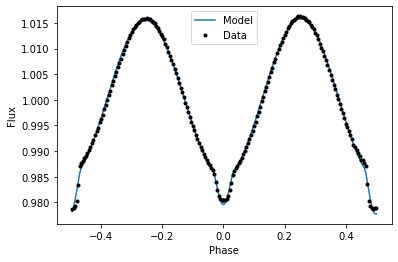

In [53]:
soln = bn.optimize(vars=['t0'], method='Nelder-Mead')
bn.plot_model()
# soln = bn.optimize(vars=['fc', 'fs'], method='Nelder-Mead')
soln = bn.optimize(vars=['t0', 'mean', 'log_f'], method='Nelder-Mead')
soln = bn.optimize(vars=['t0', 'mean', 'log_f', 'fc', 'fs'], method='Nelder-Mead')
soln = bn.optimize(vars=['rsum', 'rratio', 'incl', 'mean'], method='Nelder-Mead')
# soln = bn.optimize(vars=['rsum', 'rratio', 'incl', 'mean', 'ldc_1', 'ldc_2'], method='Nelder-Mead')
soln = bn.optimize(method='Nelder-Mead')
bn.plot_model()

In [44]:
bn.parameters

{'q': 0.5482708408500329,
 'rsum': 0.13864738147851585,
 'rratio': 1.1483335300700674,
 'fc': -0.06886323355417169,
 'fs': -0.07736089522149445,
 'sbratio': 0.9672611938827953,
 'incl': 82.74481136190134,
 't0': 1.3788898609482732e-05,
 'mean': -0.0003546659578890388,
 'log_f': -9.825510724049483,
 'gdc_1': 0.0059075553141455135,
 'gdc_2': -0.0042022028028434275}

In [ ]:
trace = bn.run_emcee()

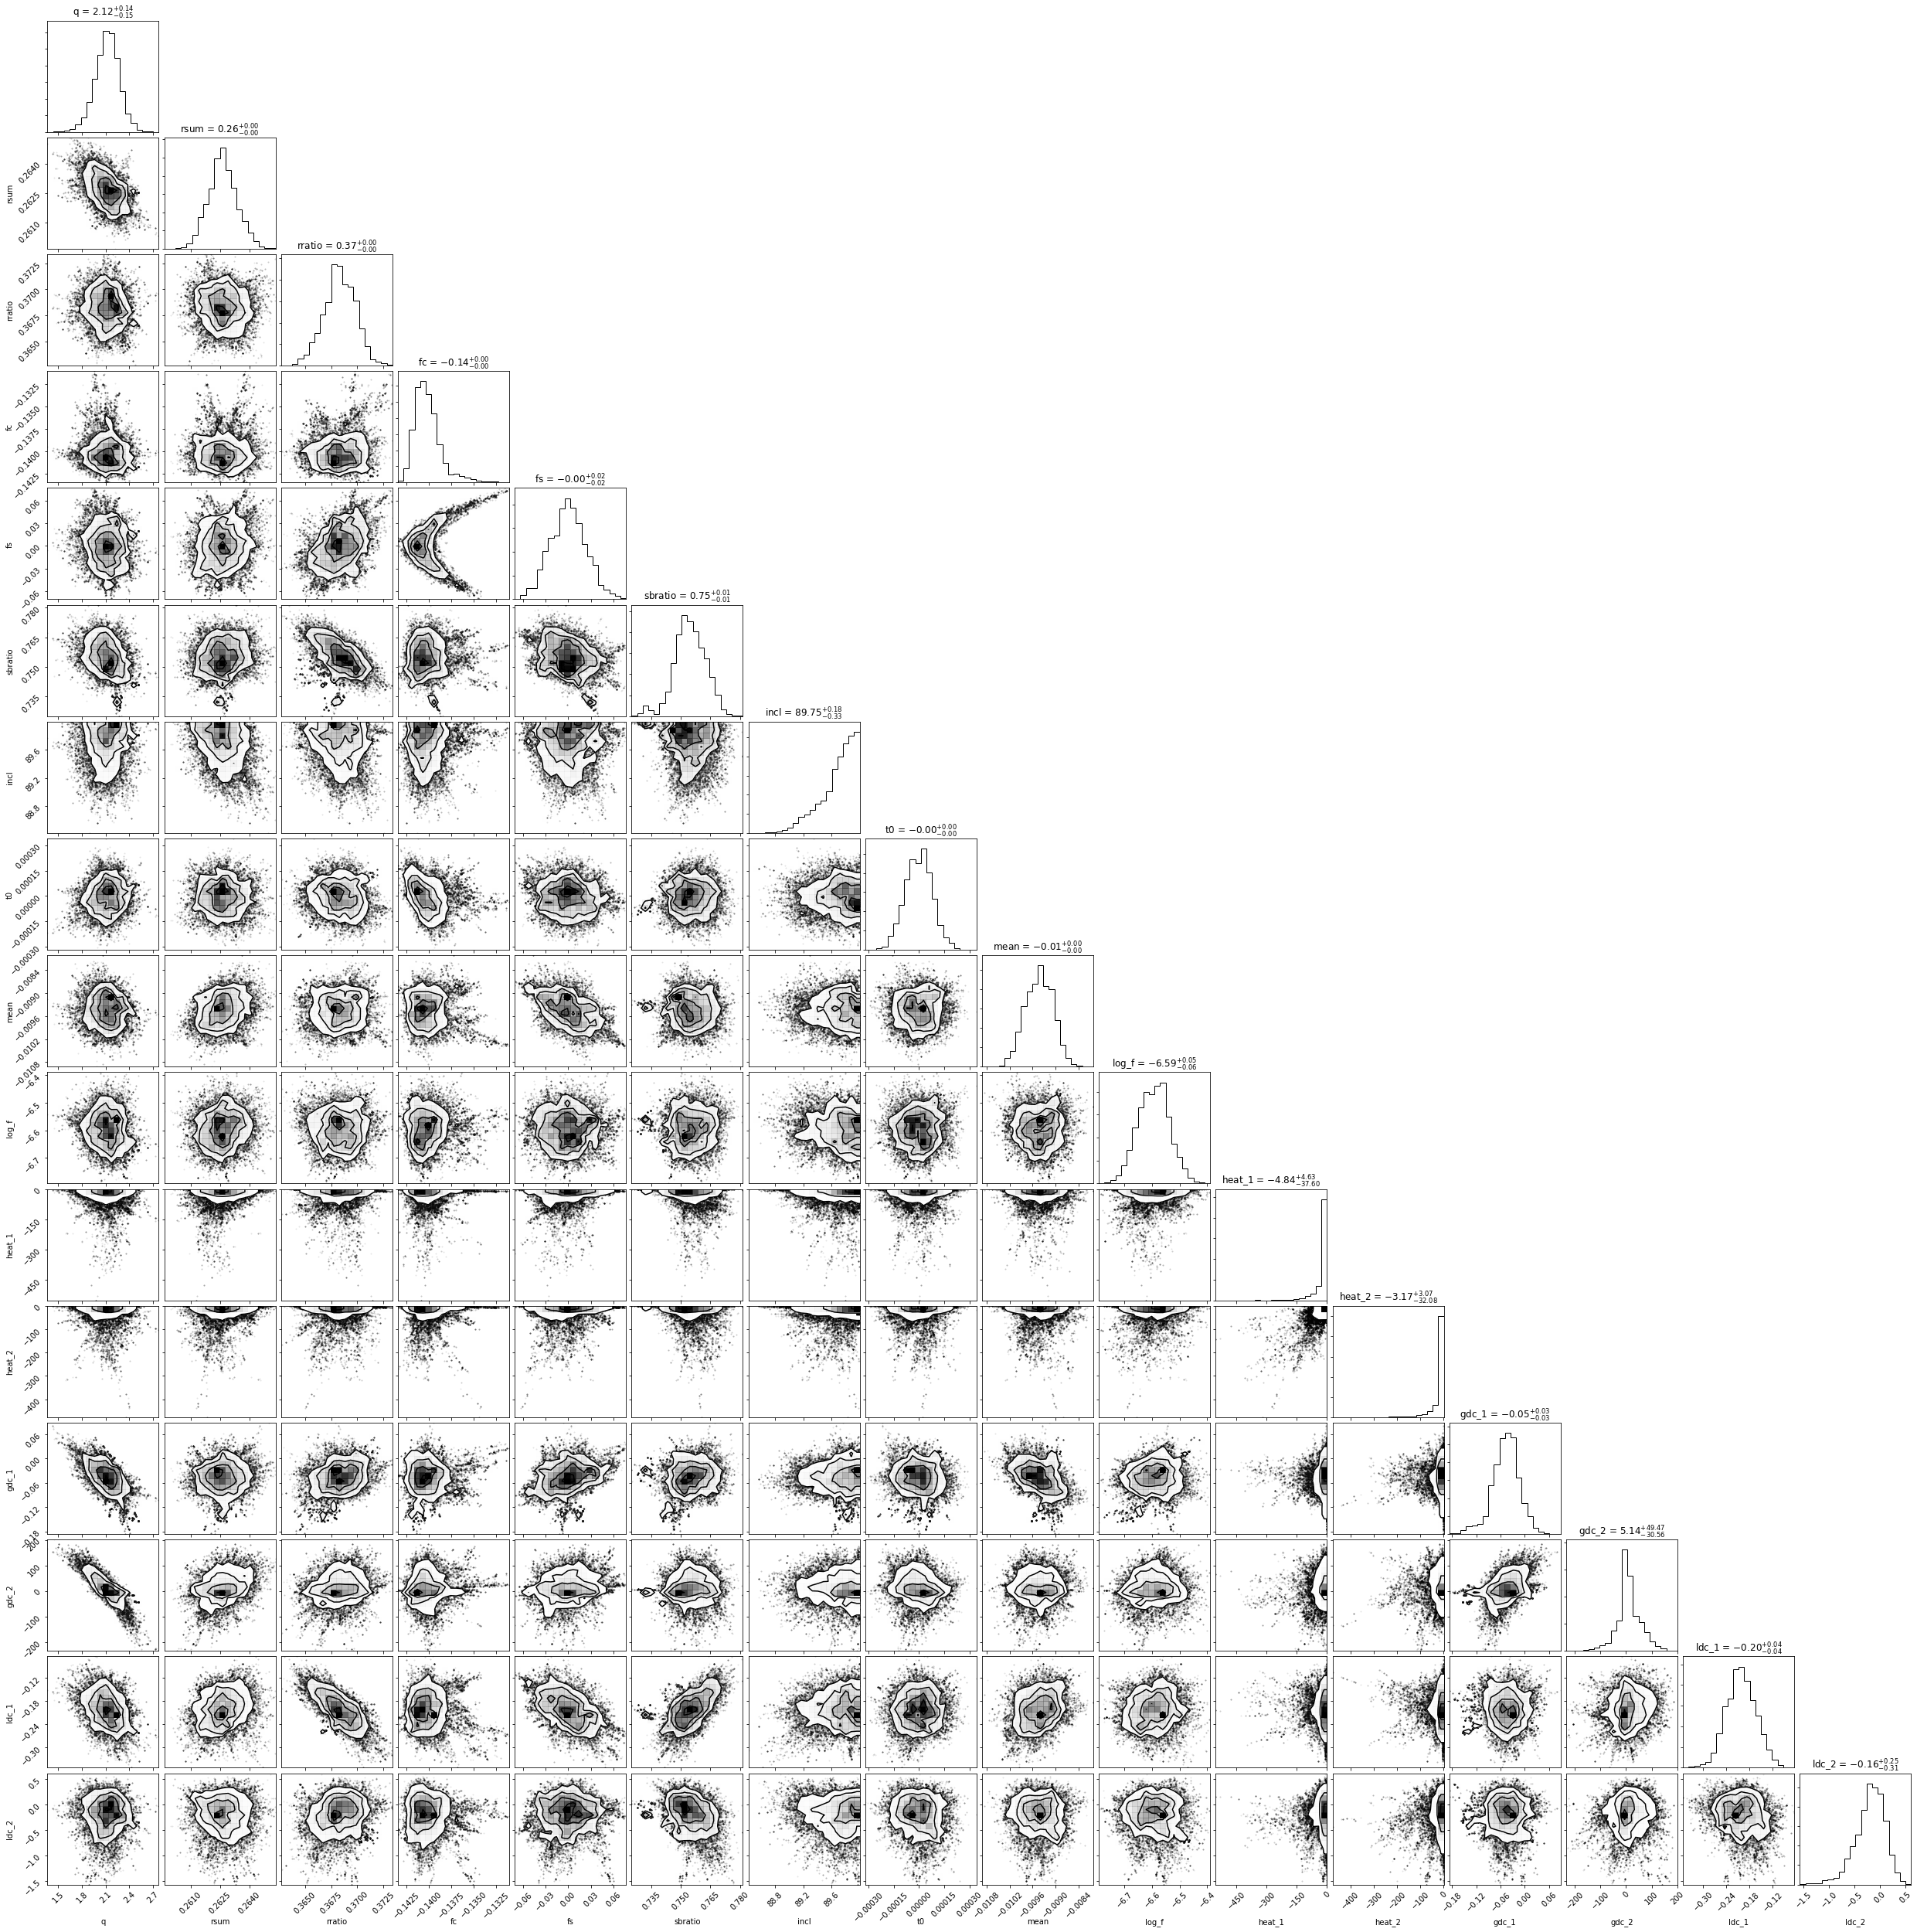

In [11]:
bn.corner_plot(trace);

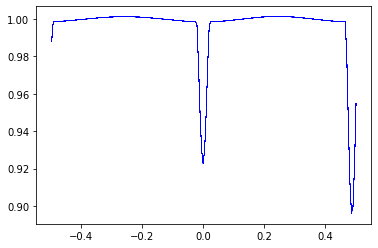

In [31]:
import phoebe
from multiprocessing import Pool
import emcee

b = phoebe.default_binary()

def lnlike(period):
    b['period@orbit'] = period[0]
    b.run_compute()
    print(period, b['period@orbit'].value)
    return 0.

pos = 1. + 1e-4*np.random.randn(5, 1)
nwalkers, ndim = pos.shape

with Pool(4) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, pool=pool)
    sampler.run_mcmc(pos, 1, progress=False);

[1.00002055] 1.0000205460475977
[0.99988465] 0.9998846484337527
[1.00006626] 1.0000662645443439
[1.00007262] 1.000072619288808
[0.99988121] 0.9998812110313238
[1.00006912] 1.0000691189760147
[0.99994864] 0.9999486351999157
[0.99984599] 0.9998459880963975
[0.99996407] 0.9999640747961726
[1.00007491] 1.0000749106696398


In [ ]:
# base = 'phoetting/showcases/grid_search/'
# db_database = np.load(base+'detached/db_database.npy')
# db_database_params = np.loadtxt(base+'detached/db_database_params.dat')
# db_test = np.load(base+'detached/db_test.npy')
# db_test_params = np.loadtxt(base+'detached/db_test_params.dat')

# db_param_names = ['q', 'r1', 'r2', 'tratio', 'incl', 'ecc', 'per0']

# i = 92
# bn = Bunyip(phase=np.linspace(-0.5, 0.5, 100), flux=db_database[i])

# bn.update_from_knn()
# print(bn.lnlike([],[]))
# bn.update_from_network()
# print(bn.lnlike([],[]))

# # bn.parameters.update({'t0':0.2})
# bn.plot_model()

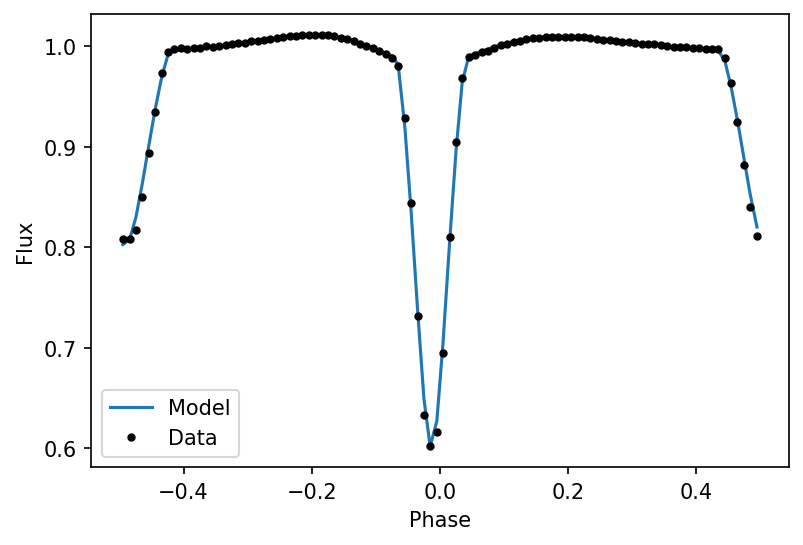

In [10]:
soln = bn.optimize(vars=['t0', 'mean'], method='Nelder-Mead')
soln = bn.optimize(vars=['t0', 'mean', 'fc', 'fs'], method='Nelder-Mead')
soln = bn.optimize(vars=['rsum', 'rratio', 'incl'], method='Nelder-Mead')
soln = bn.optimize(method='Nelder-Mead')
# soln = bn.optimize(vars=['fc', 'fs'])
bn.plot_model()

In [ ]:
soln = bn.optimize(vars=['t0'], method='Nelder-Mead')
soln = bn.optimize(vars=['t0', 'fc', 'fs'], method='Nelder-Mead')
soln = bn.optimize(vars=['rsum', 'rratio', 'incl'], method='Nelder-Mead')
soln = bn.optimize(method='Nelder-Mead')
# soln = bn.optimize(vars=['fc', 'fs'])
bn.plot_model()

In [ ]:
soln = bn.optimize(vars=['t0', 'mean'], method='Nelder-Mead')
soln = bn.optimize(vars=['t0', 'mean', 'fc', 'fs'], method='Nelder-Mead')
soln = bn.optimize(vars=['rsum', 'rratio', 'incl'], method='Nelder-Mead')
soln = bn.optimize(method='Nelder-Mead')
# soln = bn.optimize(vars=['fc', 'fs'])
bn.plot_model()

In [ ]:
esinw, ecosw = 0.1379, 0.0339
e = np.sqrt(esinw**2 + ecosw**2)
w = np.arctan(esinw/ecosw)
np.sqrt(e)*np.cos(w), np.sqrt(e)*np.sin(w)

In [40]:
e = np.linspace(0,1,1000)
w = np.linspace(0,2*np.pi, 1000)
E, W = np.meshgrid(e,w)
fs = np.sqrt(E)*np.sin(W)

In [96]:
fc = np.linspace(-0.7,0.65,1000)
fs = np.linspace(0,0.65,1000)
FC, FS = np.meshgrid(fc,fs)
ecc = FC**2 + FS**2
om = np.arctan2(FS,FC)

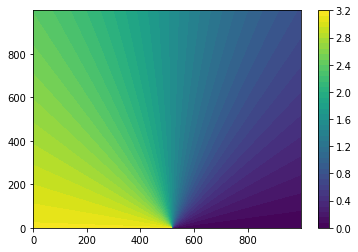

In [97]:
plt.contourf(om, levels=50)
plt.colorbar()

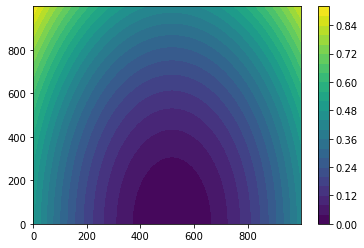

In [100]:
plt.contourf(ecc, levels=25)
plt.colorbar()

In [101]:
np.max(ecc)

0.9125

In [6]:
bounds = [
    (param-1e-3, param+1e-3) for param in list(vda.parameters.values())
]
# q, rsum, rratio, f_c, f_s, sbratio, incl, t0, mean, log_f = params

In [7]:
# bounds[1] = (0.01, 0.5)
# bounds[2] = (0.5, 1.5)
bounds[3] = (0.1,1)
bounds[4] = (0.1, 1)
bounds

[(1.5747539096746257, 1.5767539096746255),
 (0.38924333964001534, 0.39124333964001534),
 (0.8287689128298366, 0.8307689128298366),
 (0.1, 1),
 (0.1, 1),
 (0.7412205341663323, 0.7432205341663323),
 (83.85178688760207, 83.85378688760208),
 (-0.01622895635571331, -0.014228956355713307),
 (-0.001, 0.001),
 (0.0874929443666461, 0.08949294436664611)]

In [ ]:
soln = optimize.differential_evolution(vda.nll, bounds)

In [2]:
import numpy as np
np.arctan(0.1/0.1)

0.7853981633974483

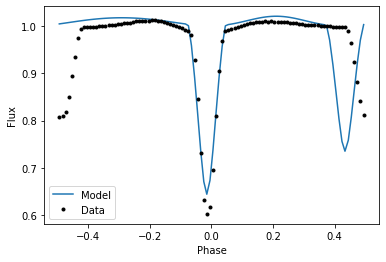

In [43]:
vda.plot_model()